In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

import sys

sys.path.append('../../')
from Dynearthsol import Dynearthsol

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [3]:
MODEL_NAMES = [
    "vel_weakening/result"
]
# Function to read time steps and times from the info file
def read_time_steps(filename):
    data = np.loadtxt(filename, usecols=(0, 2))
    time_steps = data[:, 0].astype(int)
    times = data[:, 1]
    return time_steps, times

# Function to find the closest node
def find_closest_node(coordinates, target_x, target_depth):
    distances = np.sqrt((coordinates[:, 0] - target_x) ** 2 + (coordinates[:, 1] - target_depth) ** 2)
    return np.argmin(distances)  # Return index of closest node

# Function to perform numerical calculations for each time step
def numerical(num_steps, model_name):
    des = Dynearthsol(model_name)
    
    # Storage for displacement and velocity at the closest node
    disp_4km = np.zeros([num_steps, 2], dtype=float)
    vel_4km = np.zeros([num_steps, 2], dtype=float)

    # Read initial coordinates to find closest nodes once
    coordinates0 = des.read_field(0, 'coord0')  # Initial coordinates
    node_4km = find_closest_node(coordinates0, target_x=50000, target_depth=-4050)

    for time_step in range(num_steps):
        coordinates = des.read_field(time_step, 'coordinate')  # Current coordinates
        vel = des.read_field(time_step, 'velocity')  # Velocity field
        disp = coordinates - coordinates0  # Displacement calculation

        # Store values for the closest node
        disp_4km[time_step, :] = disp[node_4km]
        vel_4km[time_step, :] = vel[node_4km]

    return disp_4km, vel_4km

# Read time steps and numerical times from the info file of one of the models
time_steps, times = read_time_steps(MODEL_NAMES[0] + '.info')
times = times / 86400 / 365.25  # Convert seconds to years

print(times)
num_steps = len(time_steps)

# Run numerical analysis
results = [numerical(num_steps, model_name) for model_name in MODEL_NAMES]
disp_4km, vel_4km = [np.squeeze(np.array(arr)) for arr in zip(*results)]

# Compute magnitude of displacement and velocity
disp_4km_mag = np.linalg.norm(disp_4km, axis=1)
vel_4km_mag = np.linalg.norm(vel_4km, axis=1)



[0.00000000e+00 4.10498897e-01 7.66109907e-01 ... 2.47063243e+03
 2.47063497e+03 2.47063750e+03]


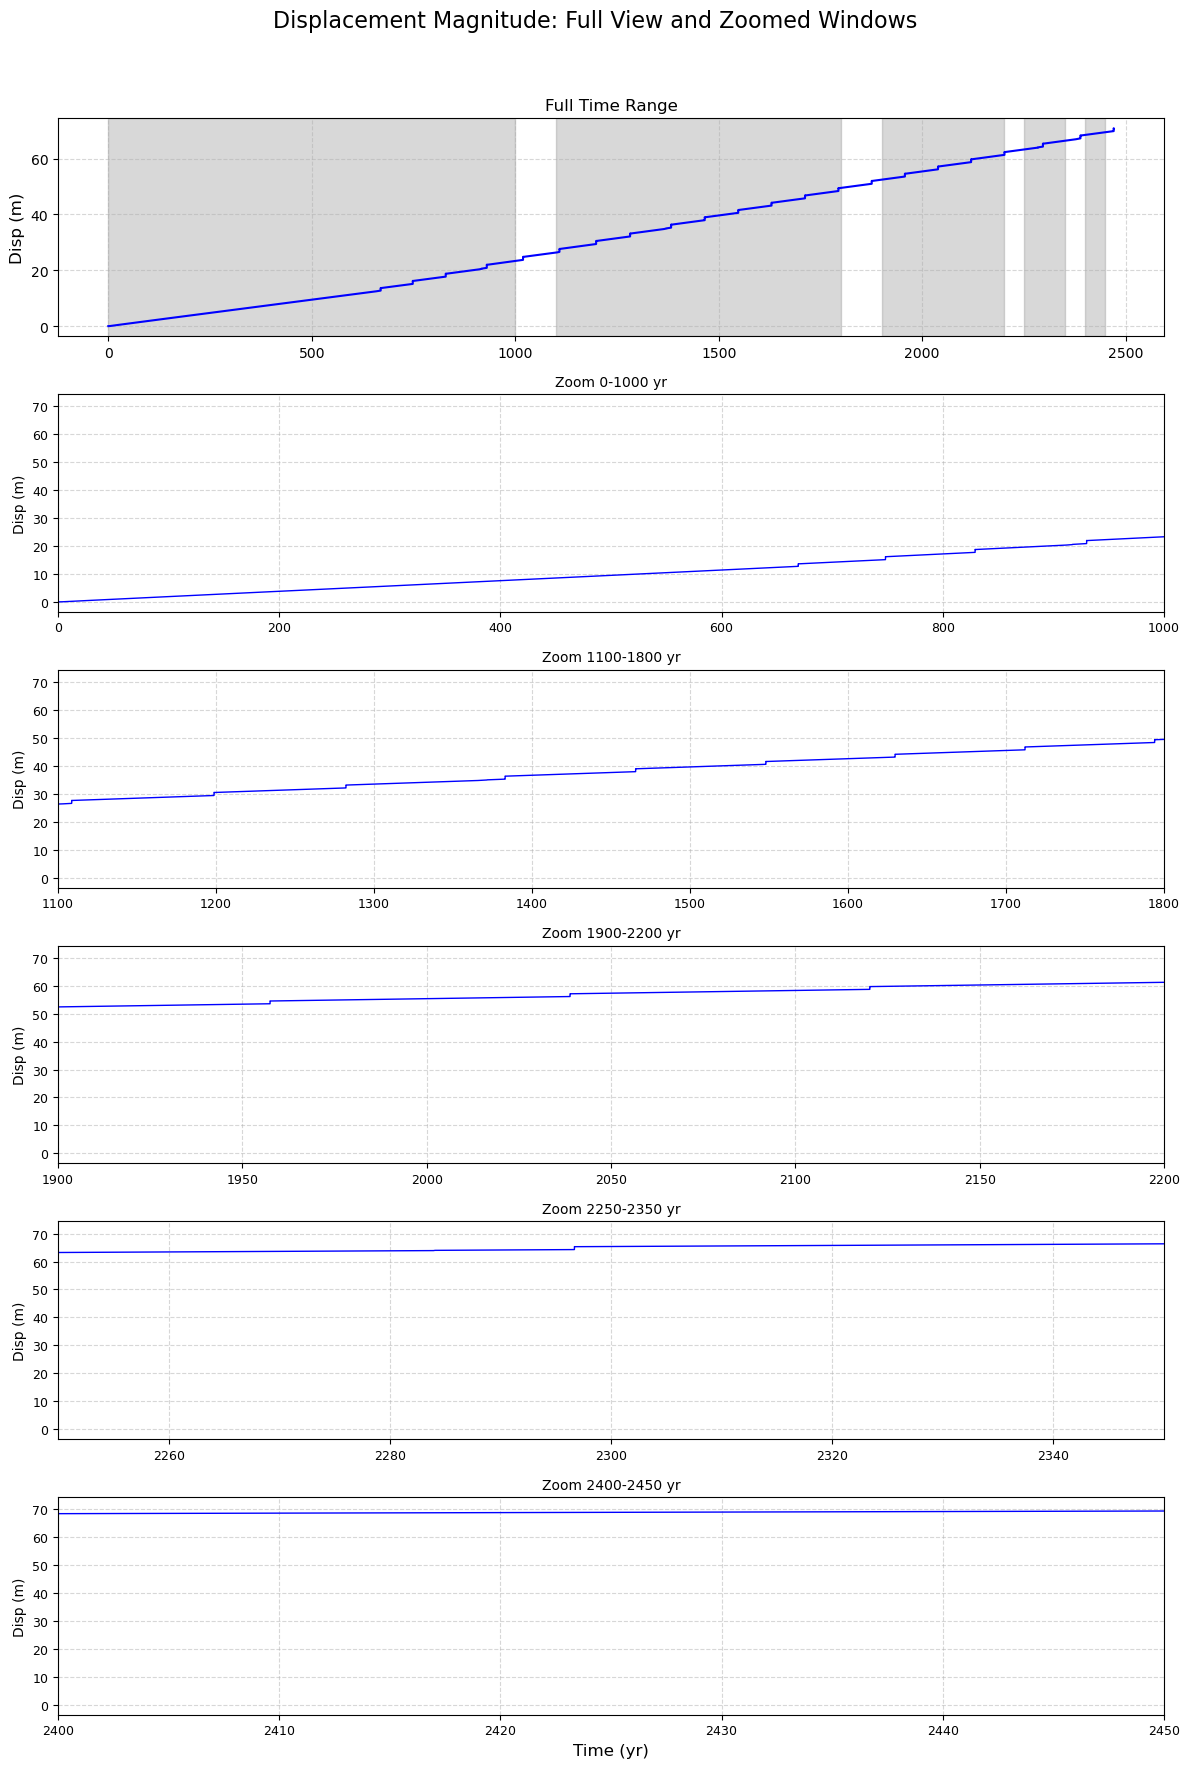

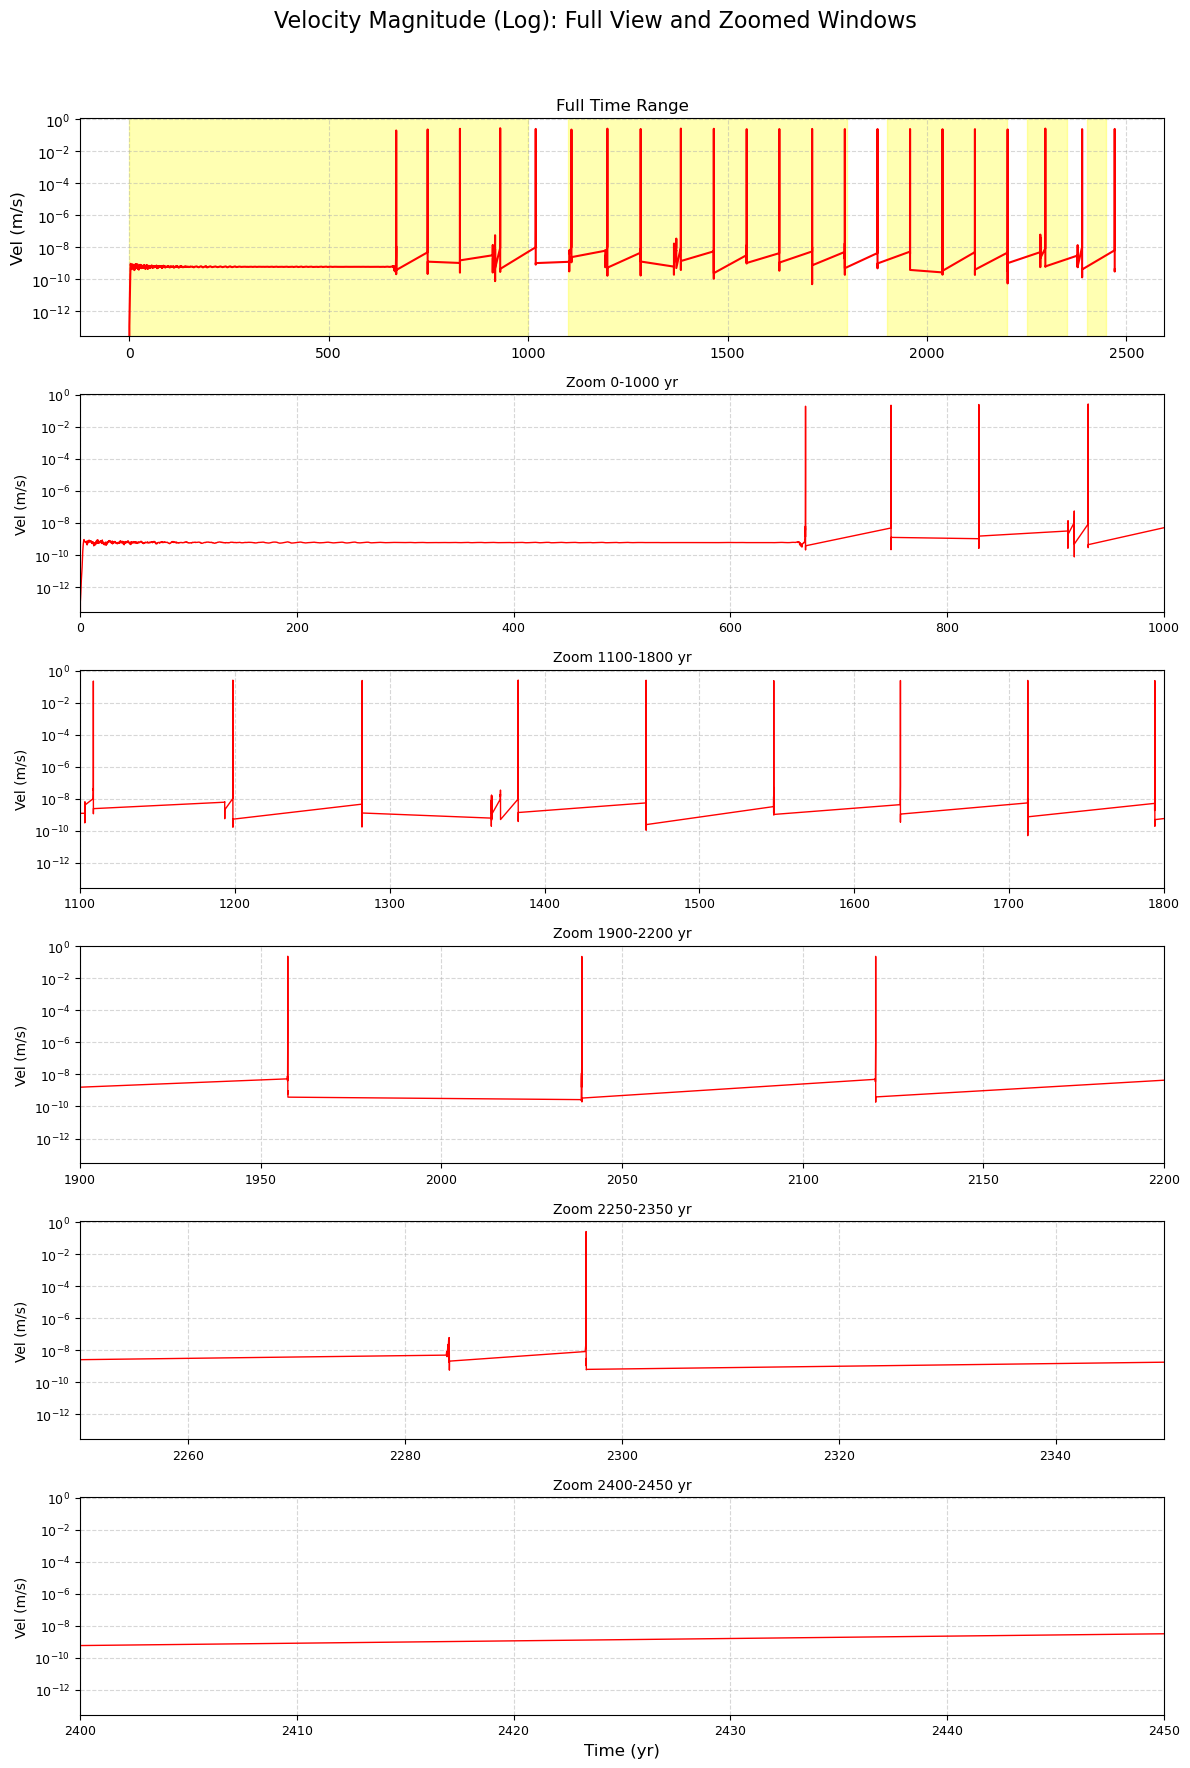

In [4]:
import matplotlib.pyplot as plt

# Define zoom intervals
zoom_windows = [(0, 1000), (1100, 1800), (1900, 2200), (2250, 2350), (2400, 2450)]

# --- Displacement Plot ---
fig_disp, axes_disp = plt.subplots(6, 1, figsize=(12, 18))  # NOT sharex
fig_disp.suptitle("Displacement Magnitude: Full View and Zoomed Windows", fontsize=16)

# Full time range
axes_disp[0].plot(times, disp_4km_mag, color='b', linewidth=1.5)
axes_disp[0].set_ylabel("Disp (m)", fontsize=12)
axes_disp[0].set_title("Full Time Range", fontsize=12)
for (start, end) in zoom_windows:
    axes_disp[0].axvspan(start, end, color='gray', alpha=0.3)
axes_disp[0].grid(True, linestyle='--', alpha=0.5)

# Zoom panels
for i, (start, end) in enumerate(zoom_windows):
    ax = axes_disp[i + 1]
    ax.plot(times, disp_4km_mag, color='b', linewidth=1.0)
    ax.set_xlim(start, end)
    ax.set_ylabel("Disp (m)", fontsize=10)
    ax.set_title(f"Zoom {start}-{end} yr", fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(labelsize=9)
axes_disp[-1].set_xlabel("Time (yr)", fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("displacement_magnitude.png", dpi=300)
plt.show()


# --- Velocity Plot ---
fig_vel, axes_vel = plt.subplots(6, 1, figsize=(12, 18))  # NOT sharex
fig_vel.suptitle("Velocity Magnitude (Log): Full View and Zoomed Windows", fontsize=16)

# Full time range
axes_vel[0].plot(times, vel_4km_mag, color='r', linewidth=1.5)
axes_vel[0].set_yscale('log')
axes_vel[0].set_ylabel("Vel (m/s)", fontsize=12)
axes_vel[0].set_title("Full Time Range", fontsize=12)
for (start, end) in zoom_windows:
    axes_vel[0].axvspan(start, end, color='yellow', alpha=0.3)
axes_vel[0].grid(True, linestyle='--', alpha=0.5, which='both')

# Zoom panels
for i, (start, end) in enumerate(zoom_windows):
    ax = axes_vel[i + 1]
    ax.plot(times, vel_4km_mag, color='r', linewidth=1.0)
    ax.set_xlim(start, end)
    ax.set_yscale('log')
    ax.set_ylabel("Vel (m/s)", fontsize=10)
    ax.set_title(f"Zoom {start}-{end} yr", fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.5, which='both')
    ax.tick_params(labelsize=9)
axes_vel[-1].set_xlabel("Time (yr)", fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("velocity_magnitude.png", dpi=300)
plt.show()

